# 1. 前準備 (csvの読み込みと紐づけ)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #seabornない人はpip installしてね
import os
from datetime import datetime
import numpy as np
from pathlib import Path

# カレントディレクトリを.pyと合わせるために以下を実行
if Path.cwd().name == "notebook":
    os.chdir("..")

# 設定
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 500)
pd.set_option('display.max_columns', 500)

# 浮動小数点数を小数点以下3桁で表示するように設定
pd.set_option('display.float_format', '{:.3f}'.format)

In [2]:
# Mac Matplotlibのデフォルトフォントをヒラギノ角ゴシックに設定
plt.rcParams['font.family'] = 'Hiragino Sans'

In [3]:
# Windows MatplotlibのデフォルトフォントをMeiryoに設定
# plt.rcParams['font.family'] = 'Meiryo'

In [4]:
# point_history.csvの読み込み
file_path_point_history = 'data/input/point_history_cleansing.csv'
df_point_history = pd.read_csv(file_path_point_history)

df_point_history = df_point_history.drop(columns=['total_amount'])    # 'total_amount'は全部N

/var/folders/98/hvq7y4l138xcz9kdprxpkw2m0000gn/T/ipykernel_98380/305371196.py:3: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_point_history = pd.read_csv(file_path_point_history)


In [5]:
# user_info.csvの読み込み
file_path_user_info = 'data/input/user_info_cleansing.csv'
df_user_info = pd.read_csv(file_path_user_info)

In [6]:
# user_infoにageとage_groupのカラムを追加
# ageの算出・追加
df_user_info['birth_day'] = pd.to_datetime(df_user_info['birth_day'], errors='coerce')    # birth_dayをdatetimeに変換
current_year = pd.Timestamp.now().year
df_user_info['age'] = current_year - df_user_info['birth_day'].dt.year

# 年代の算出・追加
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
df_user_info['age_group'] = pd.cut(df_user_info['age'], bins=bins, labels=labels, right=False)

In [7]:
# point_history.csvとuser_info.csvをmerge (左内部結合)
df_merge = pd.merge(df_point_history, df_user_info, left_on='user_id', right_on='id', how='left')

In [8]:
# マージしたコードの確認
# display(df_merge.head(100))
# df_merge["total_amount"].unique()
display(df_merge.describe())
# #print(len(df_merge["user_uid"].unique()))
# #print(df_merge.info(verbose=True, show_counts=True))
# print(df_merge['nickname'].isna().sum())

,Unnamed: 0_x,id_x,user_id,series_id,shop_id,リサイクル分類ID,amount,amount_kg,point,total_point,status,coin,rank_id,支店ID,store_latitude,store_longitude,Unnamed: 0_y,id_y,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,birth_day,zipcode,age
count,2149728.000,2149728.000,2149728.000,1295685.000,1253882.000,1253884.000,1253888.000,1253884.000,2105409.000,1253883.000,2149728.000,2149724.000,2147086.000,1248489.000,1243893.000,1243893.000,2085787.000,2085787.000,2085787.000,2085787.000,2085787.000,2085787.000,2085787.000,2085787.000,1562100,1961478.000,1562100.000
mean,1085361.322,11863325.458,42111.151,8.435,669.300,1.003,9.121,9.101,1.661,26.813,3.259,34.433,0.755,166.241,37.695,140.475,49288.296,41365.151,1659.628,21.386,410.640,241.543,6.155,0.533,1967-10-24 20:08:45.865949720,7385623.443,55.670
min,0.000,22.000,1.000,1.000,9.000,1.000,0.000,0.000,0.000,0.000,1.000,-20000.000,0.000,3.000,35.853,139.081,3.000,62.000,0.000,0.000,0.000,0.000,0.000,0.000,1920-01-01 00:00:00,1000006.000,7.000
25%,546351.750,9691203.500,11074.000,9.000,305.000,1.000,4.000,4.000,0.000,0.000,1.000,1.000,0.000,73.000,36.918,140.142,22379.000,10927.000,281.000,0.000,103.000,73.000,0.000,0.000,1960-04-04 00:00:00,3210932.000,49.000
50%,1086521.500,12993836.500,35809.000,9.000,772.000,1.000,7.000,7.000,0.000,0.000,1.000,6.000,0.000,151.000,37.803,140.448,48000.000,34790.000,861.000,0.000,218.000,140.000,0.000,0.000,1967-05-16 00:00:00,9638041.000,56.000
75%,1625353.250,14890424.250,72672.000,9.000,986.000,1.000,11.000,11.000,0.000,0.000,7.000,16.000,1.000,232.000,38.294,140.872,76605.000,70894.000,2068.000,0.000,417.000,225.000,0.000,1.000,1974-11-26 00:00:00,9820031.000,63.000
max,2164431.000,16576491.000,105518.000,20.000,1239999.000,4.000,503.000,503.000,2200.000,4216.000,7.000,15000.000,3.000,530.000,39.712,141.367,99819.000,105512.000,59900.000,3614.000,16880.000,15460.000,149.700,5.000,2016-09-01 00:00:00,9999999.000,103.000
std,623743.634,3891833.683,32727.141,2.022,1612.244,0.102,9.678,9.654,12.884,91.546,2.810,322.394,1.101,116.977,0.931,0.418,29558.598,32319.339,2818.910,76.267,895.382,622.669,21.814,0.985,NaN,3179784.574,11.241


# 2. 分析

## 2-1. rankごとの平均年間持込量kgの算出

・rank_id毎のrecycle_amount_per_year平均の算出  
・rankが高いほど、年間持ち込み量が多いという仮説を証明する(当然？)  
・rank_idは、0:ブロンズ、1:シルバー、2:ゴールド、3:プラチナ  
・1か月に15kg持ち込み続けるとランクUP。ランクダウンは不明(1か月15kgを達成しないとダウン説、、？)  
※以下の手順を踏むと「rank毎の1回の持ち込み量平均」になってしまうので注意  
　　① amount_kgは1回の持ち込み量。これをrank_id毎にsumする  
　　② rank_idそれぞれの出現回数をsumする  
　　③ ①を②で割る  

In [9]:
# まずそれぞれのカラムの基本統計量を確認しておく
print('recycle_amount_per_year')
print(df_merge['recycle_amount_per_year'].describe())
print('------------------')
print('rank_id')
print(df_merge['rank_id'].describe())
print('------------------')
print('rank_idのユニーク')
print(df_merge['rank_id'].unique())

recycle_amount_per_year
count   2085787.000
mean        241.543
std         622.669
min           0.000
25%          73.000
50%         140.000
75%         225.000
max       15460.000
Name: recycle_amount_per_year, dtype: float64
------------------
rank_id
count   2147086.000
mean          0.755
std           1.101
min           0.000
25%           0.000
50%           0.000
75%           1.000
max           3.000
Name: rank_id, dtype: float64
------------------
rank_idのユニーク
[ 0.  2.  1.  3. nan]


※rankは3（プラチナ）が不在な点に注意

In [10]:
# user_idの重複行を削除（非効率だと思いつつ、、、）
df_merge_duplicates_user_id = df_merge.drop_duplicates(subset='user_id')

ランク毎の持ち込みamountの平均 = df_merge.groupby('rank_id')['recycle_amount_per_year'].mean()
ランク毎の持ち込みamountの平均

rank_id
0.000   125.483
1.000   287.655
2.000   290.110
3.000   680.981
Name: recycle_amount_per_year, dtype: float64

### 得られた示唆

・ランクが高いほど、平均年間持ち込み量は多い  
　→「持ち込み量が多いから、ランクが上がった」という解釈の方が正しい？  
 ・rankのカラムのみ、user_infoに紐づけておくと、user_infoの情報量が増えてよいかも


## 2-2. ユーザ個人に着目して指針を得る 

### 2-2-1. トップユーザのamount_kg推移

・point、coin、rankが、ユーザの持ち込み量に影響を与えているのか確認  
・rankを維持したい人


In [11]:
# 'user_id'の各値の出現回数を計算
user_id_counts = df_merge['user_id'].value_counts().reset_index()
user_id_counts.columns = ['user_id', 'count']

# 元のDataFrameにcountをマージ
df_merge = df_merge.merge(user_id_counts, on='user_id')

# 出現回数に基づいてソート（降順）
df_merge = df_merge.sort_values(by='count', ascending=False)

In [12]:
# 重複を削除して、上位100名のcountをtableで俯瞰する
df_merged_duplicates_user_id = df_merge.drop_duplicates(subset='user_id')
top_100 = df_merged_duplicates_user_id.head(100)
top_100

,Unnamed: 0_x,id_x,user_id,series_id,shop_id,shop_name,card_id,リサイクル分類ID,amount,amount_kg,point,total_point,status,coin,rank_id,use_date,created_at,updated_at,支店ID,super,shop_name_1,shop_id_1,created_at_1,updated_at_1,store_opening_time,store_closing_time,rps_opening_time,rps_closing_time,store_latitude,store_longitude,Unnamed: 0_y,id_y,nickname,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,gender,birth_day,zipcode,age,age_group,count
727277,877594,12011006,27133,10.000,326.000,みやぎ生協大河原店,3150100225982,1.000,1.000,1.000,2.000,89.000,1,6.000,3.000,2023-05-04 11:38:27,2023-05-05 04:04:18,2023-05-05 04:04:18,339.000,みやぎ生協,大河原店,326,2022-04-23 03:15:28,2023-03-31 20:40:44,09:00:00,21:30:00,09:00:00,19:00:00,38.049,140.731,23464.000,27133.000,春,2282.000,129.000,2896.000,2060.000,0.000,0.000,女,1950-11-29,9891245.000,73.000,71-80,3127
34257,1558776,14657714,1152,3.000,11.000,ビフレ東通店,315bifre074937,1.000,0.000,0.000,1.000,142.000,1,0.000,3.000,2023-09-09 15:13:36,2023-09-10 04:00:19,2023-09-10 04:00:19,4.000,ビフレ,東通店,11,2021-09-21 04:02:39,2023-04-07 16:15:20,09:30:00,22:00:00,09:30:00,20:30:00,39.712,140.142,7122.000,1152.000,畠山寿子,21800.000,113.000,3410.000,807.500,0.000,0.000,女,1947-01-06,NaN,76.000,71-80,2071
1430569,1097110,13044986,38423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,3,0.000,0.000,2023-06-27 12:22:59,2023-06-27 12:22:59,2023-06-27 12:22:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35194.000,38423.000,FITS開発者,705.000,10.000,10.000,10.000,0.000,0.000,男,NaT,9800811.000,NaN,NaN,2027
38049,279391,7042287,912,3.000,168.000,ビフレ新庄店,315bifre056848,1.000,0.000,0.000,1.000,92.000,1,0.000,0.000,2022-08-10 19:53:47,2022-08-11 04:00:21,2022-08-11 04:00:21,7.000,ビフレ,新庄店,168,2021-09-21 04:12:05,2023-04-07 16:24:30,09:00:00,20:50:00,09:00:00,20:00:00,38.760,140.289,90117.000,912.000,ハルヤマサンポ,317.000,21.000,305.200,100.750,0.000,1.000,男,1948-03-30,9960027.000,75.000,71-80,2003
1061304,1922680,15828773,37378,9.000,NaN,NaN,7600001477764093,NaN,NaN,NaN,NaN,NaN,4,-500.000,3.000,2023-11-01 09:02:23,2023-11-01 09:02:23,2023-11-01 09:02:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34111.000,37378.000,Gue,11350.000,0.000,10040.000,7252.000,0.000,0.000,女,NaT,9810964.000,NaN,NaN,1764
881438,1136109,13196472,24467,9.000,1194.000,NaN,7600005574265474,1.000,6.000,6.000,0.000,0.000,1,36.000,3.000,2023-07-03 11:48:25,2023-07-05 00:07:11,2023-07-05 00:07:11,399.000,ヨークベニマル,鹿沼千渡店,ITOYOKADO0001194,2022-06-24 13:53:29,2023-03-31 20:40:44,09:30:00,21:30:00,09:30:00,20:00:00,36.567,139.778,20695.000,24467.000,ことにーにー,2230.000,0.000,11420.000,9170.000,0.000,0.000,男,1970-07-24,3220025.000,53.000,51-60,1670
391143,1361350,13986736,8130,9.000,132.000,NaN,7600090538362922,1.000,6.000,6.000,0.000,0.000,1,36.000,3.000,2023-08-08 20:15:04,2023-08-10 00:21:51,2023-08-10 00:21:51,138.000,ヨークベニマル,泉が丘店,ITOYOKADO0000132,2021-09-22 00:59:13,2023-04-08 15:08:35,09:30:00,21:45:00,09:30:00,21:00:00,36.568,139.919,79632.000,8130.000,ポイントゲッター,33180.000,0.000,7144.000,6916.000,0.000,0.000,男,NaT,3210951.000,NaN,NaN,1196
44256,117691,3415216,1083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,3,5000.000,3.000,2022-02-01 11:33:43,2022-02-01 11:33:43,2022-02-01 11:33:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6366.000,1083.000,オバラ,361.000,80.000,2920.000,898.000,0.000,0.000,女,1963-06-26,NaN,60.000,61-70,1173
31522,48836,1438443,1593,3.000,11.000,ビフレ東通店,315bifre016209,1.000,0.000,0.000,1.000,149.000,1,0.000,0.000,2021-06-22 10:02:11,2021-06-23 02:00:52,2021-06-23 02:00:52,4.000,ビフレ,東通店,11,2021-09-21 04:02:39,2023-04-07 16:15:20,09:30:00,22:00:00,09:30:00,20:30:00,39.712,140.142,11832.000,1593.000,sakura,2208.000,98.000,543.000,185.500,0.000,0.000,女,1977-12-17,NaN,46.000,41-50,1172
910457,616755,10310482,27451,9.000,NaN,NaN,7600000824961709,NaN,NaN,NaN,NaN,NaN,4,-500.000,3.000,2023-02-07 00:00:44,2023-02-07 00:00:44,2023-02-07 00:00:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23787.000,27451.000

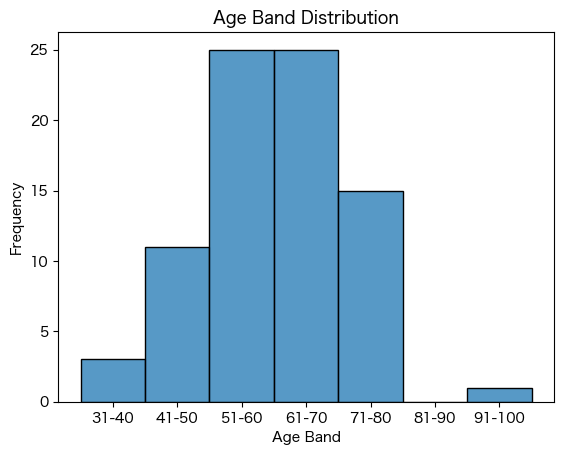

In [13]:
# top_100の年代別人数を表示
sns.histplot(data=top_100, x='age_group')

plt.title('Age Band Distribution')
plt.xlabel('Age Band')
plt.ylabel('Frequency')

plt.show()

In [14]:
# # 特定の人のamount_kgの推移を確認
# # 特定の人のデータのみ抽出
# target_user_id = 1152
# df_merge_target = df_merge[df_merge['user_id'] == target_user_id]
# df_merge_target = df_merge_target.sort_values(by='use_date', ascending=True)

# df_merge_target['use_date'] = pd.to_datetime(df_merge_target['use_date'])

# # use_dateを月ごとに集約（データ数が多すぎて折れ線グラフが見づらい）
# df_merge_target_monthly = df_merge_target[['use_date', 'amount_kg']].resample('M', on='use_date').sum()

# # 集約されたデータで折れ線グラフを作成
# plt.figure(figsize=(10, 6))
# plt.plot(df_merge_target_monthly.index, df_merge_target_monthly['amount_kg'], marker='o')
# plt.title('Monthly Average of Amount (kg)')
# plt.xlabel('Month')
# plt.ylabel('Average Amount (kg)')

# # データをすべて使って折れ線グラフを作成
# plt.figure(figsize=(10, 6))
# plt.plot(df_merge_target_monthly['use_date'], df_merge_target_monthly['rank_id'], marker='o')
# plt.title('rank')
# plt.xlabel('date')
# plt.ylabel('rank')
# plt.show()

# # coinが付与され始めた時期のデータを表示
# filtered_df  = df_merge_target[df_merge_target['coin'] > 0]
# filtered_df.head()


### まとめ

・15kgを達成しても、すぐにランクが上がらない矛盾あり  
・15kgを未達でもすぐにランクが下がらない矛盾あり  
・アプリを利用していなくても履歴は残る。アプリを利用しているか否かは'coin'(付与コイン)で判断する  

## 2-3. rankシステムの効果測定

・rank_idのレコード

In [15]:
# # Convert the 'use_date' column to datetime format for easier manipulation
# df_merge['use_date'] = pd.to_datetime(df_merge['use_date'])

# # To measure the effect of rank_id changes on recycling amount, we'll analyze the data as follows:
# # 1. Group the data by user_id and month.
# # 2. Calculate the total recycling amount per user per month.
# # 3. Compare the rank_id of each month with the previous month and observe any changes.
# # 4. Analyze the relationship between rank_id changes and changes in recycling amount.

# # Group by user_id and month, then sum the recycling amounts and take the last rank_id for each group
# df_grouped = df_merge.groupby(['user_id', pd.Grouper(key='use_date', freq='M')]).agg({'amount_kg':'sum', 'rank_id':'last'}).reset_index()

# # To analyze the effect of rank change, we need to compare the rank_id with the previous month's rank_id for each user.
# df_grouped['previous_rank_id'] = df_grouped.groupby('user_id')['rank_id'].shift(1)

# # Drop the first month for each user since we don't have the previous month's rank_id
# df_grouped = df_grouped.dropna(subset=['previous_rank_id'])

# # Now, we can analyze the relationship between rank_id changes and recycling amount changes.
# # For example, we can calculate the difference in recycling amount from the previous month and see how it relates to rank_id changes.
# df_grouped['amount_change'] = df_grouped.groupby('user_id')['amount_kg'].diff()

# df_grouped.head(300)

In [16]:
# TODO: amount_kgの平均を出してしまっているので、user　rank_idごとのamount_kgの合計を出さないといけない？？
# Calculate the average recycling amount for each user and each rank
avg_amount_per_user_rank = df_merge.groupby(['user_id', 'rank_id'])['amount_kg'].mean().reset_index()

# To compare the average recycling amount of different ranks for each user, we need to pivot the data
pivot_table = avg_amount_per_user_rank.pivot(index='user_id', columns='rank_id', values='amount_kg')

# Calculate the difference between each rank's average recycling amount for each user
# For simplicity, we'll calculate the difference between consecutive ranks (rank N and rank N-1)
rank_differences = pivot_table.diff(axis=1)

In [17]:
rank_differences.head(100)

rank_id,0.000,1.000,2.000,3.000
user_id,,,,
1,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN
61,NaN,3.400,NaN,NaN
62,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN
65,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN
67,NaN,-0.771,0.440,NaN
69,NaN,NaN,NaN,NaN


## 1,2,3ごとの平均値を出してみる

In [18]:
average_difference_rank = rank_differences.mean(skipna=True)
average_difference_rank

rank_id
0.000      NaN
1.000   -0.943
2.000   -0.478
3.000   -0.740
dtype: float64